## FDMS TME3  

Kaggle [How Much Did It Rain? II](https://www.kaggle.com/c/how-much-did-it-rain-ii)

Florian Toque & Paul Willot  

# Data Vize

In [1]:
# from __future__ import exam_success
from __future__ import absolute_import
from __future__ import print_function

%matplotlib inline
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd
import scipy.stats as stats

# Sk cheats
from sklearn.cross_validation import cross_val_score  # cross val
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import Imputer   # get rid of nan

* 13.765.202 lines in train.csv  
*  8.022.757 lines in test.csv  

### Load the dataset

In [2]:
%%time
filename = "data/reduced_train_100000.csv"
#filename = "data/reduced_test_100000.csv"
raw = pd.read_csv(filename)
raw = raw.set_index('Id')

CPU times: user 286 ms, sys: 44.4 ms, total: 330 ms
Wall time: 332 ms


In [3]:
raw['Expected'].describe()

count    100000.000000
mean        129.579825
std         687.622542
min           0.010000
25%           0.254000
50%           1.016000
75%           3.556002
max       32740.617000
Name: Expected, dtype: float64

Per wikipedia, a **value of more than 421 mm/h is considered "Extreme/large hail"**  
If we encounter the value 327.40 meter per hour, we should probably start building Noah's ark  
Therefor, it seems reasonable to **drop values too large**, considered as outliers

In [4]:
# Considering that the gauge may concentrate the rainfall, we set the cap to 1000
# Comment this line to analyse the complete dataset 
l = len(raw)
raw = raw[raw['Expected'] < 1000]
print("Dropped %d (%0.2f%%)"%(l-len(raw),(l-len(raw))/float(l)*100))

Dropped 4175 (4.17%)


In [5]:
raw.head(5)

,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
Id,,,,,,,,,,,,,,,,,,,,,
1,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,16,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,25,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,35,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,45,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254


### Quick analysis for the sparsity by column

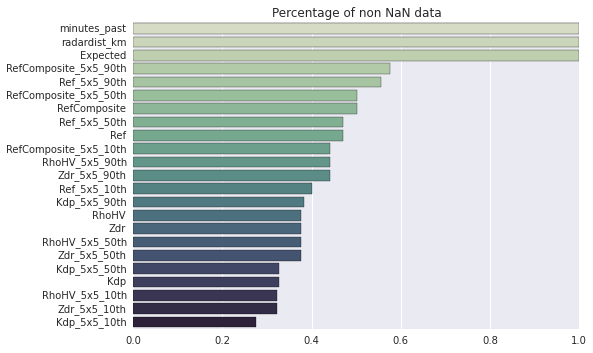

In [6]:
l = float(len(raw["minutes_past"]))
comp = [[1-raw[i].isnull().sum()/l , i] for i in raw.columns]
comp.sort(key=lambda x: x[0], reverse=True)

sns.barplot(zip(*comp)[0],zip(*comp)[1],palette=sns.cubehelix_palette(len(comp), start=.5, rot=-.75))
plt.title("Percentage of non NaN data")
plt.show()

We see that except for the fixed features **minutes_past, radardist_km and Expected** the dataset is mainly sparse.  
Let's transform the dataset to conduct more analysis

We regroup the data by ID

In [8]:
# We select all features except for the minutes past,
# because we ignore the time repartition of the sequence for now

features_columns = list([u'Ref', u'Ref_5x5_10th',
       u'Ref_5x5_50th', u'Ref_5x5_90th', u'RefComposite',
       u'RefComposite_5x5_10th', u'RefComposite_5x5_50th',
       u'RefComposite_5x5_90th', u'RhoHV', u'RhoHV_5x5_10th',
       u'RhoHV_5x5_50th', u'RhoHV_5x5_90th', u'Zdr', u'Zdr_5x5_10th',
       u'Zdr_5x5_50th', u'Zdr_5x5_90th', u'Kdp', u'Kdp_5x5_10th',
       u'Kdp_5x5_50th', u'Kdp_5x5_90th'])

def getXy(raw):
    selected_columns = list([ u'radardist_km', u'Ref', u'Ref_5x5_10th',
       u'Ref_5x5_50th', u'Ref_5x5_90th', u'RefComposite',
       u'RefComposite_5x5_10th', u'RefComposite_5x5_50th',
       u'RefComposite_5x5_90th', u'RhoHV', u'RhoHV_5x5_10th',
       u'RhoHV_5x5_50th', u'RhoHV_5x5_90th', u'Zdr', u'Zdr_5x5_10th',
       u'Zdr_5x5_50th', u'Zdr_5x5_90th', u'Kdp', u'Kdp_5x5_10th',
       u'Kdp_5x5_50th', u'Kdp_5x5_90th'])
    
    data = raw[selected_columns]
    
    docX, docY = [], []
    for i in data.index.unique():
        if isinstance(data.loc[i],pd.core.series.Series):
            m = [data.loc[i].as_matrix()]
            docX.append(m)
            docY.append(float(raw.loc[i]["Expected"]))
        else:
            m = data.loc[i].as_matrix()
            docX.append(m)
            docY.append(float(raw.loc[i][:1]["Expected"]))
    X , y = np.array(docX) , np.array(docY)
    return X,y

In [9]:
raw.index.unique()

array([   1,    2,    3, ..., 9539, 9540, 9541])

In [62]:
raw.isnull().sum()

minutes_past                 0
radardist_km                 0
Ref                      50835
Ref_5x5_10th             57384
Ref_5x5_50th             50679
Ref_5x5_90th             42662
RefComposite             47805
RefComposite_5x5_10th    53550
RefComposite_5x5_50th    47708
RefComposite_5x5_90th    40565
RhoHV                    59785
RhoHV_5x5_10th           64924
RhoHV_5x5_50th           59800
RhoHV_5x5_90th           53615
Zdr                      59785
Zdr_5x5_10th             64924
Zdr_5x5_50th             59800
Zdr_5x5_90th             53615
Kdp                      64507
Kdp_5x5_10th             69361
Kdp_5x5_50th             64457
Kdp_5x5_90th             59198
Expected                     0
dtype: int64

_How much observations is there for each ID ?_

Average gauge observation in mm: 17.55


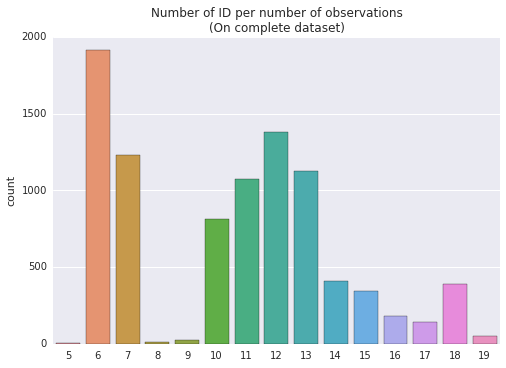

In [63]:
X,y=getXy(raw)

tmp = []
for i in X:
    tmp.append(len(i))
tmp = np.array(tmp)
sns.countplot(tmp,order=range(tmp.min(),tmp.max()+1))
plt.title("Number of ID per number of observations\n(On complete dataset)")
plt.plot()

print("Average gauge observation in mm: %0.2f"%y.mean())

We see there is a lot of ID with 6 or 12 observations, that mean one every 5 or 10 minutes on average.  

In [64]:
pd.DataFrame(y).describe()

,0
count,9100.000000
mean,17.547618
std,82.682028
min,0.010000
25%,0.254000
50%,0.762000
75%,2.794001
max,876.300500



Now let's do the analysis on different subsets:

### On fully filled dataset

In [31]:
#noAnyNan = raw.loc[raw[features_columns].dropna(how='any').index.unique()]
noAnyNan = raw.dropna()

In [66]:
noAnyNan.isnull().sum()

minutes_past             0
radardist_km             0
Ref                      0
Ref_5x5_10th             0
Ref_5x5_50th             0
Ref_5x5_90th             0
RefComposite             0
RefComposite_5x5_10th    0
RefComposite_5x5_50th    0
RefComposite_5x5_90th    0
RhoHV                    0
RhoHV_5x5_10th           0
RhoHV_5x5_50th           0
RhoHV_5x5_90th           0
Zdr                      0
Zdr_5x5_10th             0
Zdr_5x5_50th             0
Zdr_5x5_90th             0
Kdp                      0
Kdp_5x5_10th             0
Kdp_5x5_50th             0
Kdp_5x5_90th             0
Expected                 0
dtype: int64

Average gauge observation in mm: 4.80


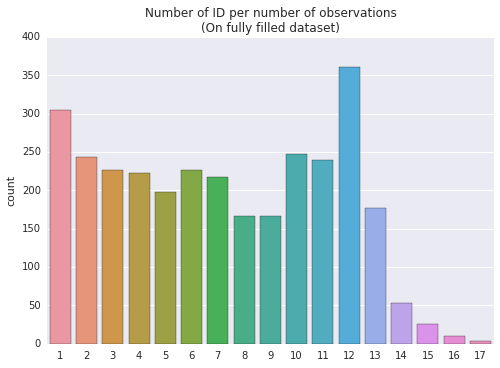

In [32]:
X,y=getXy(noAnyNan)

tmp = []
for i in X:
    tmp.append(len(i))
tmp = np.array(tmp)
sns.countplot(tmp,order=range(tmp.min(),tmp.max()+1))
plt.title("Number of ID per number of observations\n(On fully filled dataset)")
plt.plot()

print("Average gauge observation in mm: %0.2f"%y.mean())

In [33]:
pd.DataFrame(y).describe()

,0
count,3093.000000
mean,4.804508
std,23.151911
min,0.010000
25%,0.508000
50%,1.778001
75%,3.810002
max,675.999400


In [17]:
noFullNan = raw.loc[raw[features_columns].dropna(how='all').index.unique()]

In [67]:
noFullNan.isnull().sum()

minutes_past                 0
radardist_km                 0
Ref                      25775
Ref_5x5_10th             32324
Ref_5x5_50th             25619
Ref_5x5_90th             17602
RefComposite             22745
RefComposite_5x5_10th    28490
RefComposite_5x5_50th    22648
RefComposite_5x5_90th    15505
RhoHV                    34725
RhoHV_5x5_10th           39864
RhoHV_5x5_50th           34740
RhoHV_5x5_90th           28555
Zdr                      34725
Zdr_5x5_10th             39864
Zdr_5x5_50th             34740
Zdr_5x5_90th             28555
Kdp                      39447
Kdp_5x5_10th             44301
Kdp_5x5_50th             39397
Kdp_5x5_90th             34138
Expected                     0
dtype: int64

Average gauge observation in mm: 9.65


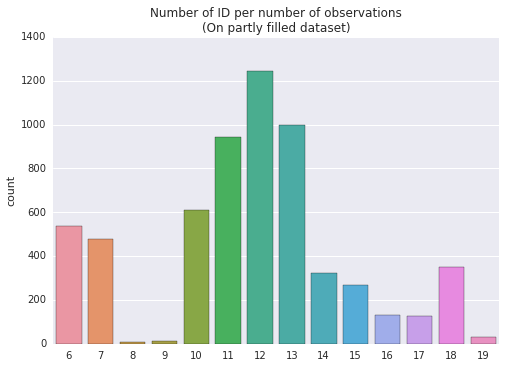

In [18]:
X,y=getXy(noFullNan)

tmp = []
for i in X:
    tmp.append(len(i))
tmp = np.array(tmp)
sns.countplot(tmp,order=range(tmp.min(),tmp.max()+1))
plt.title("Number of ID per number of observations\n(On partly filled dataset)")
plt.plot()

print("Average gauge observation in mm: %0.2f"%y.mean())

In [19]:
pd.DataFrame(y).describe()

,0
count,6058.000000
mean,9.650996
std,57.325040
min,0.010000
25%,0.254000
50%,1.270001
75%,3.302002
max,876.300500


In [69]:
fullNan = raw.drop(raw[features_columns].dropna(how='all').index)

In [68]:
fullNan.isnull().sum()

minutes_past                 0
radardist_km                 0
Ref                      25060
Ref_5x5_10th             25060
Ref_5x5_50th             25060
Ref_5x5_90th             25060
RefComposite             25060
RefComposite_5x5_10th    25060
RefComposite_5x5_50th    25060
RefComposite_5x5_90th    25060
RhoHV                    25060
RhoHV_5x5_10th           25060
RhoHV_5x5_50th           25060
RhoHV_5x5_90th           25060
Zdr                      25060
Zdr_5x5_10th             25060
Zdr_5x5_50th             25060
Zdr_5x5_90th             25060
Kdp                      25060
Kdp_5x5_10th             25060
Kdp_5x5_50th             25060
Kdp_5x5_90th             25060
Expected                     0
dtype: int64

Average gauge observation in mm: 33.27


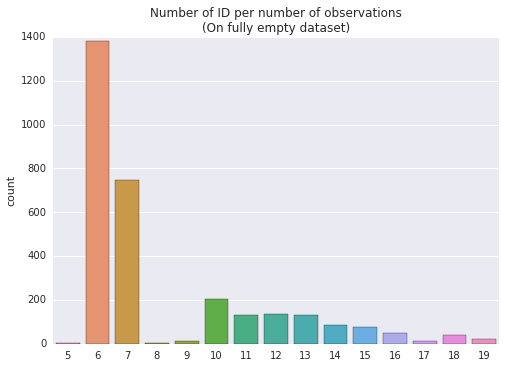

In [21]:
X,y=getXy(fullNan)

tmp = []
for i in X:
    tmp.append(len(i))
tmp = np.array(tmp)
sns.countplot(tmp,order=range(tmp.min(),tmp.max()+1))
plt.title("Number of ID per number of observations\n(On fully empty dataset)")
plt.plot()

print("Average gauge observation in mm: %0.2f"%y.mean())

In [22]:
pd.DataFrame(y).describe()

,0
count,3042.000000
mean,33.273368
std,116.353313
min,0.010000
25%,0.254000
50%,0.445000
75%,1.016000
max,774.700440


**Strangely we notice that the less observations there is, the more it rains on average**  
**However more of the expected rainfall fall below 0.5**  
_What prediction should we make if there is no data?_

In [23]:
print("%d observations" %(len(raw)))
#print("%d fully filled, %d partly filled, %d fully empty"
#      %(len(noAnyNan),len(noFullNan),len(raw)-len(noFullNan)))
print("%0.1f%% fully filled, %0.1f%% partly filled, %0.1f%% fully empty"
      %(len(noAnyNan)/float(len(raw))*100,
        len(noFullNan)/float(len(raw))*100,
        (len(raw)-len(noFullNan))/float(len(raw))*100))

95825 observations
39.1% fully filled, 73.8% partly filled, 26.2% fully empty


---
# Predicitons


As a first try, we make predictions on the complete data, and return the 50th percentile and uncomplete and fully empty data

In [25]:
etreg = ExtraTreesRegressor(n_estimators=100, max_depth=None, min_samples_split=1, random_state=0)

In [34]:
X,y=getXy(noAnyNan)
XX = [np.array(t).mean(0) for t in X]

In [35]:
split = 0.2
ps = int(len(XX) * (1-split))
X_train = XX[:ps]
y_train = y[:ps]
X_test = XX[ps:]
y_test = y[ps:]

In [36]:
%%time
etreg.fit(X_train,y_train)

CPU times: user 884 ms, sys: 16.7 ms, total: 901 ms
Wall time: 910 ms


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=1, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
          verbose=0, warm_start=False)

In [37]:
%%time
et_score = cross_val_score(etreg, XX, y, cv=5)
print("Score: %s\tMean: %.03f"%(et_score,et_score.mean()))

Score: [ 0.51407557  0.15938088  0.69138431  0.09297001  0.00505057]	Mean: 0.293
CPU times: user 4.45 s, sys: 59.4 ms, total: 4.51 s
Wall time: 4.5 s


In [38]:
err = (etreg.predict(X_test)-y_test)**2
err.sum()/len(err)

216.45597252585003

In [41]:
r = random.randrange(len(X_train))
print(r)
print(etreg.predict(X_train[r]))
print(y_train[r])

1767
[ 4.8260026]
4.8260026


In [61]:
r = random.randrange(len(X_test))
print(r)
print(etreg.predict(X_test[r]))
print(y_test[r])

173
[ 5.98220317]
10.668006


---

In [72]:
filename = "data/reduced_test_5000.csv"
test = pd.read_csv(filename)
test = test.set_index('Id')

In [71]:
features_columns = list([u'Ref', u'Ref_5x5_10th',
       u'Ref_5x5_50th', u'Ref_5x5_90th', u'RefComposite',
       u'RefComposite_5x5_10th', u'RefComposite_5x5_50th',
       u'RefComposite_5x5_90th', u'RhoHV', u'RhoHV_5x5_10th',
       u'RhoHV_5x5_50th', u'RhoHV_5x5_90th', u'Zdr', u'Zdr_5x5_10th',
       u'Zdr_5x5_50th', u'Zdr_5x5_90th', u'Kdp', u'Kdp_5x5_10th',
       u'Kdp_5x5_50th', u'Kdp_5x5_90th'])

def getX(raw):
    selected_columns = list([ u'radardist_km', u'Ref', u'Ref_5x5_10th',
       u'Ref_5x5_50th', u'Ref_5x5_90th', u'RefComposite',
       u'RefComposite_5x5_10th', u'RefComposite_5x5_50th',
       u'RefComposite_5x5_90th', u'RhoHV', u'RhoHV_5x5_10th',
       u'RhoHV_5x5_50th', u'RhoHV_5x5_90th', u'Zdr', u'Zdr_5x5_10th',
       u'Zdr_5x5_50th', u'Zdr_5x5_90th', u'Kdp', u'Kdp_5x5_10th',
       u'Kdp_5x5_50th', u'Kdp_5x5_90th'])
    
    data = raw[selected_columns]
    
    docX= []
    for i in data.index.unique():
        if isinstance(data.loc[i],pd.core.series.Series):
            m = [data.loc[i].as_matrix()]
            docX.append(m)
        else:
            m = data.loc[i].as_matrix()
            docX.append(m)
    X = np.array(docX)
    return X

[]

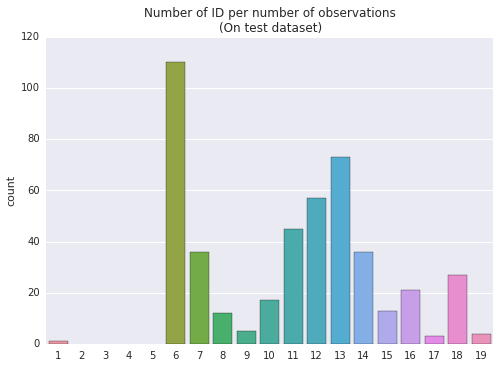

In [74]:
X=getX(test)

tmp = []
for i in X:
    tmp.append(len(i))
tmp = np.array(tmp)
sns.countplot(tmp,order=range(tmp.min(),tmp.max()+1))
plt.title("Number of ID per number of observations\n(On test dataset)")
plt.plot()

#print("Average gauge observation in mm: %0.2f"%y.mean())

In [ ]:
etreg.predict(X_test)

In [84]:
testFull = test.dropna()

In [85]:
X=getX(testFull)
XX = [np.array(t).mean(0) for t in X]

In [86]:
pd.DataFrame(etreg.predict(XX)).describe()

,0
count,97.000000
mean,7.097759
std,10.345521
min,0.786404
25%,2.491525
50%,4.143092
75%,7.000075
max,71.207602


In [91]:
predFull = zip(testFull.index.unique(),etreg.predict(XX))

In [100]:
b = np.empty(len(a))
b.fill(3.14)

In [101]:
zip(a,b)

[(1, 3.1400000000000001), (2, 3.1400000000000001), (3, 3.1400000000000001)]

In [104]:
predFull[:10]

[(3, 5.3862345638416684),
 (4, 4.6898841213033329),
 (7, 4.0931654237333355),
 (10, 18.859948837136667),
 (11, 7.0000753707133354),
 (13, 2.4915246228641674),
 (14, 5.6516529828833333),
 (22, 2.3812455522718348),
 (23, 3.1052015925900003),
 (30, 4.3187973353333344)]

In [102]:
testNan = test.drop(test[features_columns].dropna(how='all').index)

In [116]:
tmp = np.empty(len(testNan))
tmp.fill(0.445000)   # 50th percentile of full Nan dataset
predNan = zip(testNan.index.unique(),tmp)

In [106]:
predNan[:10]

[(5, 5.3862345638416684),
 (9, 4.6898841213033329),
 (15, 4.0931654237333355),
 (16, 18.859948837136667),
 (17, 7.0000753707133354),
 (20, 2.4915246228641674),
 (21, 5.6516529828833333),
 (24, 2.3812455522718348),
 (25, 3.1052015925900003),
 (28, 4.3187973353333344)]

In [109]:
testLeft = test.drop(testNan.index.unique()).drop(testFull.index.unique())

In [117]:
tmp = np.empty(len(testLeft))
tmp.fill(1.27)   # 50th percentile of full Nan dataset
predLeft = zip(testLeft.index.unique(),tmp)

In [118]:
len(testFull.index.unique())

97

In [119]:
len(testNan.index.unique())

190

In [120]:
len(testLeft.index.unique())

173

In [122]:
pred = predFull + predNan + predLeft

In [124]:
pred.sort(key=lambda x: x[0], reverse=False)

In [134]:
submission = pd.DataFrame(pred)
submission.columns = ["Id","Expected"]
submission.head()

,Id,Expected
0,1,1.270000
1,2,1.270000
2,3,5.386235
3,4,4.689884
4,5,0.445000


In [136]:
submission.to_csv("first_submit.csv",index=False)